In [306]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle

In [286]:
def filter_butter(data, ordem, freq_corte, freq_amostragem):
    ''' Entrada: Dados que serão filtrados - shape(n,3)'''
    ''' Entrada: Ordem do filtro'''
    ''' Entrada: Frequência de corte do filtro'''
    ''' Entrada: Frequência de amostragem do filtro'''
    ''' Saída: Dados filtrados - shape(n,3)'''
    
    # Criar o filtro
    create_filter = signal.butter(ordem, freq_corte, btype='low', fs=freq_amostragem, output='sos')
    
    # Criar a variável que irá receber os dados filtrados
    data_filter = np.zeros(data.shape)
    
    # Aplicar o filtro
    data_filter[:,0] = signal.sosfiltfilt(create_filter, data[:,0])
    data_filter[:,1] = signal.sosfiltfilt(create_filter, data[:,1])
    data_filter[:,2] = signal.sosfiltfilt(create_filter, data[:,2])
    
    return data_filter  

In [287]:
def mean_filter(data, number_of_points, step=1):
    
    ''' Entrada: Vetor de dados que serão filtrados = data(n,1) '''
    ''' Saída: Vetor de dados filtrados = mean_feature(n,1)'''
    mean_feature = []
    for i in range(0, number_of_points):
        mean_feature.append(np.mean(data[0: i+1]))
    if number_of_points > 1:
        for i in range(0, len(data) - number_of_points, step):
            mean_feature.append(
                np.mean(data[i: number_of_points + i]))
    else:
        return data
    return np.array(mean_feature)

In [288]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [422]:
''' Alterar o número do Voluntário e a Chave de Repetição'''

voluntary = 23
key = 'S1_Synched'

voluntary = str(voluntary)


''' Alterar o número do Voluntário Referência e a Chave de Repetição Referência'''

ref_voluntary = 10 
ref_key = 'S1_Synched'

ref_voluntary = str(ref_voluntary)


In [423]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

### Separando os dados de aceleração para cada sensor

'Hip' 'RightUpLeg' 'LeftUpLeg' 'Head' 'Neck' 'Spine3' 'Spine2' 'Spine1' 'Spine'

In [424]:
Hip = data.iloc[:,0:3].values
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Head = data.iloc[:,9:12].values
Neck = data.iloc[:,12:15].values
Spine3 = data.iloc[:,15:18].values
Spine2 = data.iloc[:,18:21].values
Spine1 = data.iloc[:,21:24].values
Spine = data.iloc[:,24:27].values

In [425]:
# Definindo a frequência de amostragem
freq_amostragem = 120

# Definindo a ordem do filtro 
ordem = 2

Aplicando filtro de 0.5 e 3 Hz

In [426]:
# Filtrar em 0.5 Hz os dados de aceleração das IMUs para comparação
Hip_filter_05Hz = filter_butter(Hip, ordem, 0.5, freq_amostragem)
RightUpLeg_filter_05Hz = filter_butter(RightUpLeg, ordem, 0.5, freq_amostragem)
LeftUpLeg_filter_05Hz = filter_butter(LeftUpLeg, ordem, 0.5, freq_amostragem)
Head_filter_05Hz = filter_butter(Head, ordem, 0.5, freq_amostragem)
Neck_filter_05Hz = filter_butter(Neck, ordem, 0.5, freq_amostragem)
Spine3_filter_05Hz = filter_butter(Spine3, ordem, 0.5, freq_amostragem)
Spine2_filter_05Hz = filter_butter(Spine2, ordem, 0.5, freq_amostragem)
Spine1_filter_05Hz = filter_butter(Spine1, ordem, 0.5, freq_amostragem)
Spine_filter_05Hz = filter_butter(Spine, ordem, 0.5, freq_amostragem)

# Filtrar em 3 Hz os dados de aceleração das IMUs para comparação
Hip_filter_3Hz = filter_butter(Hip, ordem, 3, freq_amostragem)
RightUpLeg_filter_3Hz = filter_butter(RightUpLeg, ordem, 3, freq_amostragem)
LeftUpLeg_filter_3Hz = filter_butter(LeftUpLeg, ordem, 3, freq_amostragem)
Head_filter_3Hz = filter_butter(Head, ordem, 3, freq_amostragem)
Neck_filter_3Hz = filter_butter(Neck, ordem, 3, freq_amostragem)
Spine3_filter_3Hz = filter_butter(Spine3, ordem, 3, freq_amostragem)
Spine2_filter_3Hz = filter_butter(Spine2, ordem, 3, freq_amostragem)
Spine1_filter_3Hz = filter_butter(Spine1, ordem, 3, freq_amostragem)
Spine_filter_3Hz = filter_butter(Spine, ordem, 3, freq_amostragem)


Aplicando a conversão de dados de IMU para ângulos

In [427]:
# Transformar dados de aceleração NÃO filtrados em dados de ângulo
angle_rad_hip, angle_hip = acc_to_angle(Hip)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(RightUpLeg)
angle_rad_left_up_leg, angle_left_up_leg = acc_to_angle(LeftUpLeg)
angle_rad_head, angle_head = acc_to_angle(Head)
angle_rad_neck, angle_neck = acc_to_angle(Neck)
angle_rad_spine3, angle_spine3 = acc_to_angle(Spine3)
angle_rad_spine2, angle_spine2 = acc_to_angle(Spine2)
angle_rad_spine1, angle_spine1 = acc_to_angle(Spine1)
angle_rad_spine, angle_spine = acc_to_angle(Spine)

# Transformar dados de aceleração filtrados em dados de ângulo
angle_rad_Hip_filter_05Hz, angle_Hip_filter_05Hz = acc_to_angle(Hip_filter_05Hz)
angle_rad_RightUpLeg_filter_05Hz, angle_RightUpLeg_filter_05Hz = acc_to_angle(RightUpLeg_filter_05Hz)
angle_rad_LeftUpLeg_filter_05Hz, angle_LeftUpLeg_filter_05Hz = acc_to_angle(LeftUpLeg_filter_05Hz)
angle_rad_Head_filter_05Hz, angle_Head_filter_05Hz = acc_to_angle(Head_filter_05Hz)
angle_rad_Neck_filter_05Hz, angle_Neck_filter_05Hz = acc_to_angle(Neck_filter_05Hz)
angle_rad_Spine3_filter_05Hz, angle_Spine3_filter_05Hz = acc_to_angle(Spine3_filter_05Hz)
angle_rad_Spine2_filter_05Hz, angle_Spine2_filter_05Hz = acc_to_angle(Spine2_filter_05Hz)
angle_rad_Spine1_filter_05Hz, angle_Spine1_filter_05Hz = acc_to_angle(Spine1_filter_05Hz)
angle_rad_Spine_filter_05Hz, angle_Spine_filter_05Hz = acc_to_angle(Spine_filter_05Hz)

# Transformar dados de aceleração filtrados em dados de ângulo
angle_rad_Hip_filter_3Hz, angle_Hip_filter_3Hz = acc_to_angle(Hip_filter_3Hz)
angle_rad_RightUpLeg_filter_3Hz, angle_RightUpLeg_filter_3Hz = acc_to_angle(RightUpLeg_filter_3Hz)
angle_rad_LeftUpLeg_filter_3Hz, angle_LeftUpLeg_filter_3Hz = acc_to_angle(LeftUpLeg_filter_3Hz)
angle_rad_Head_filter_3Hz, angle_Head_filter_3Hz = acc_to_angle(Head_filter_3Hz)
angle_rad_Neck_filter_3Hz, angle_Neck_filter_3Hz = acc_to_angle(Neck_filter_3Hz)
angle_rad_Spine3_filter_3Hz, angle_Spine3_filter_3Hz = acc_to_angle(Spine3_filter_3Hz)
angle_rad_Spine2_filter_3Hz, angle_Spine2_filter_3Hz = acc_to_angle(Spine2_filter_3Hz)
angle_rad_Spine1_filter_3Hz, angle_Spine1_filter_3Hz = acc_to_angle(Spine1_filter_3Hz)
angle_rad_Spine_filter_3Hz, angle_Spine_filter_3Hz = acc_to_angle(Spine_filter_3Hz)

# definindo o tempo em segundos das amostras de comparação
t_hip = np.linspace(0, len(Hip) / freq_amostragem, len(Hip))
t_right_up_leg = np.linspace(0, len(RightUpLeg) / freq_amostragem, len(RightUpLeg))
t_left_up_leg = np.linspace(0, len(LeftUpLeg) / freq_amostragem, len(LeftUpLeg))
t_head = np.linspace(0, len(Head) / freq_amostragem, len(Head))
t_neck = np.linspace(0, len(Neck) / freq_amostragem, len(Neck))
t_spine3 = np.linspace(0, len(Spine3) / freq_amostragem, len(Spine3))
t_spine2 = np.linspace(0, len(Spine2) / freq_amostragem, len(Spine2))
t_spine1 = np.linspace(0, len(Spine1) / freq_amostragem, len(Spine1))
t_spine = np.linspace(0, len(Spine) / freq_amostragem, len(Spine))

# Aplicando o DTW

In [428]:
# Perna Direita, Esquerda e Pescoço

# Filtrar os dados de aceleração das IMUs
ref_RightUpLeg = ref_data.iloc[:,3:6].values
ref_LeftUpLeg = ref_data.iloc[:,6:9].values
ref_Neck = ref_data.iloc[:,12:15].values

# definindo o tempo em segundos das amostras de referência
ref_t_right_up_leg = np.linspace(0, len(ref_RightUpLeg) / freq_amostragem, len(ref_RightUpLeg))
ref_t_left_up_leg = np.linspace(0, len(ref_LeftUpLeg) / freq_amostragem, len(ref_LeftUpLeg))
ref_t_neck = np.linspace(0, len(ref_Neck) / freq_amostragem, len(ref_Neck))

# Filtrar em 0.5 Hz os dados de aceleração das IMUs para comparação
ref_RightUpLeg_filter_05Hz = filter_butter(ref_RightUpLeg, ordem, 0.5, freq_amostragem)
ref_LeftUpLeg_filter_05Hz = filter_butter(ref_LeftUpLeg, ordem, 0.5, freq_amostragem)
ref_Neck_filter_05Hz = filter_butter(ref_Neck, ordem, 0.5, freq_amostragem)

# Filtrar em 3 Hz os dados de aceleração das IMUs para comparação
ref_RightUpLeg_filter_3Hz = filter_butter(ref_RightUpLeg, ordem, 3, freq_amostragem)
ref_LeftUpLeg_filter_3Hz = filter_butter(ref_LeftUpLeg, ordem, 3, freq_amostragem)
ref_Neck_filter_3Hz = filter_butter(ref_Neck, ordem, 3, freq_amostragem)


# Transformar dados de aceleração filtrados em dados de ângulo
ref_angle_rad_RightUpLeg_filter_05Hz, ref_angle_RightUpLeg_filter_05Hz = acc_to_angle(ref_RightUpLeg_filter_05Hz)
ref_angle_rad_LeftUpLeg_filter_05Hz, ref_angle_LeftUpLeg_filter_05Hz = acc_to_angle(ref_LeftUpLeg_filter_05Hz)
ref_angle_rad_Neck_filter_05Hz, ref_angle_Neck_filter_05Hz = acc_to_angle(ref_Neck_filter_05Hz)

# Transformar dados de aceleração filtrados em dados de ângulo
ref_angle_rad_RightUpLeg_filter_3Hz, ref_angle_RightUpLeg_filter_3Hz = acc_to_angle(ref_RightUpLeg_filter_3Hz)
ref_angle_rad_LeftUpLeg_filter_3Hz, ref_angle_LeftUpLeg_filter_3Hz = acc_to_angle(ref_LeftUpLeg_filter_3Hz)
ref_angle_rad_Neck_filter_3Hz, ref_angle_Neck_filter_3Hz = acc_to_angle(ref_Neck_filter_3Hz)

## Duas formas de aplicar o DTW, os resultados foram muito semelhantes, porém a fastdtw leva um menor tempo de processamento

In [429]:
''' Usando a função fastdtw '''

# Aplicando as transformações do DTW para 0.5 Hz
distance_LeftUpLeg_05Hz, paths_LeftUpLeg_05Hz = fastdtw(ref_angle_LeftUpLeg_filter_05Hz, angle_LeftUpLeg_filter_05Hz, 
                                                        dist=euclidean)
distance_Neck_05Hz, paths_Neck_05Hz = fastdtw(ref_angle_Neck_filter_05Hz, angle_Neck_filter_05Hz, dist=euclidean)

# Aplicando as transformações do DTW para 3 Hz
distance_LeftUpLeg_3Hz, paths_LeftUpLeg_3Hz = fastdtw(ref_angle_LeftUpLeg_filter_3Hz, angle_LeftUpLeg_filter_3Hz, 
                                                        dist=euclidean)
distance_Neck_3Hz, paths_Neck_3Hz = fastdtw(ref_angle_Neck_filter_3Hz, angle_Neck_filter_3Hz, dist=euclidean)

In [465]:
''' Usando a função dtw '''

# Aplicando as transformações do DTW para 0.5 Hz
#paths_LeftUpLeg_05Hz = dtw.warping_path(ref_angle_LeftUpLeg_filter_05Hz, angle_LeftUpLeg_filter_05Hz)
#paths_Neck_05Hz = dtw.warping_path(ref_angle_Neck_filter_05Hz, angle_Neck_filter_05Hz)

# Aplicando as transformações do DTW para 3 Hz
#paths_LeftUpLeg_3Hz = dtw.warping_path(ref_angle_LeftUpLeg_filter_3Hz, angle_LeftUpLeg_filter_3Hz)
#paths_Neck_3Hz = dtw.warping_path(ref_angle_Neck_filter_3Hz, angle_Neck_filter_3Hz)


In [466]:
paths_LeftUpLeg_05Hz = np.array(paths_LeftUpLeg_05Hz)
paths_Neck_05Hz = np.array(paths_Neck_05Hz)

paths_LeftUpLeg_3Hz = np.array(paths_LeftUpLeg_3Hz)
paths_Neck_3Hz = np.array(paths_Neck_3Hz)

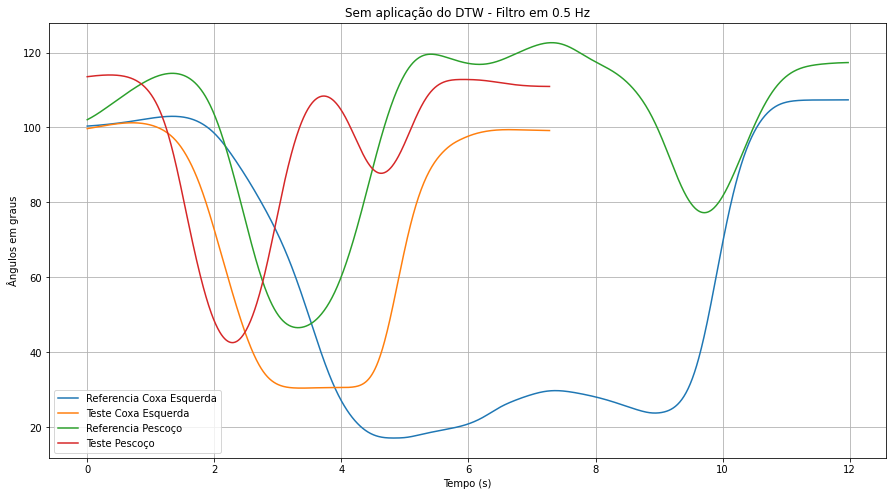

In [467]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_t_left_up_leg, ref_angle_LeftUpLeg_filter_05Hz, label = 'Referencia Coxa Esquerda')
plt.plot(t_left_up_leg, angle_LeftUpLeg_filter_05Hz, label = 'Teste Coxa Esquerda')
plt.plot(ref_t_neck, ref_angle_Neck_filter_05Hz, label = 'Referencia Pescoço')
plt.plot(t_neck, angle_Neck_filter_05Hz, label = 'Teste Pescoço')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Tempo (s)')
plt.title('Sem aplicação do DTW - Filtro em 0.5 Hz')
plt.grid()
plt.show()

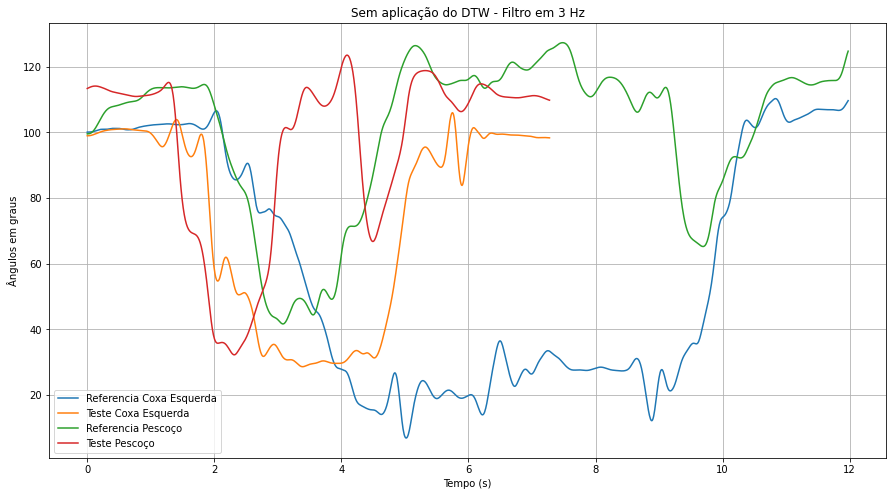

In [468]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_t_left_up_leg, ref_angle_LeftUpLeg_filter_3Hz, label = 'Referencia Coxa Esquerda')
plt.plot(t_left_up_leg, angle_LeftUpLeg_filter_3Hz, label = 'Teste Coxa Esquerda')
plt.plot(ref_t_neck, ref_angle_Neck_filter_3Hz, label = 'Referencia Pescoço')
plt.plot(t_neck, angle_Neck_filter_3Hz, label = 'Teste Pescoço')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Tempo (s)')
plt.title('Sem aplicação do DTW - Filtro em 3 Hz')
plt.grid()
plt.show()

Vetor de tempo para o DTW

In [469]:
# Vetor de tempo para 0.5 Hz
ref_t_left_up_leg_DTW05 = np.linspace(0, len(ref_LeftUpLeg) / freq_amostragem, len(paths_LeftUpLeg_05Hz[:,0]))
ref_t_neck_DTW05 = np.linspace(0, len(ref_Neck) / freq_amostragem, len(paths_Neck_05Hz[:,1]))

t_left_up_leg_DTW05 = np.linspace(0, len(LeftUpLeg) / freq_amostragem, len(paths_LeftUpLeg_05Hz[:,1]))
t_neck_DTW05 = np.linspace(0, len(Neck) / freq_amostragem, len(paths_Neck_05Hz[:,1]))

# Vetor de tempo para 3 Hz
ref_t_left_up_leg_DTW3 = np.linspace(0, len(ref_LeftUpLeg) / freq_amostragem, len(paths_LeftUpLeg_3Hz[:,0]))
ref_t_neck_DTW3 = np.linspace(0, len(ref_Neck) / freq_amostragem, len(paths_Neck_3Hz[:,1]))

t_left_up_leg_DTW3 = np.linspace(0, len(LeftUpLeg) / freq_amostragem, len(paths_LeftUpLeg_3Hz[:,1]))
t_neck_DTW3 = np.linspace(0, len(Neck) / freq_amostragem, len(paths_Neck_3Hz[:,1]))

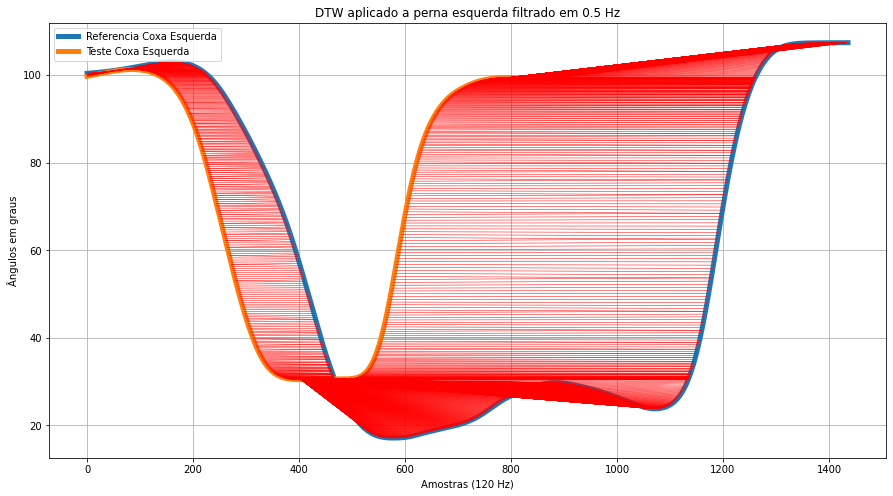

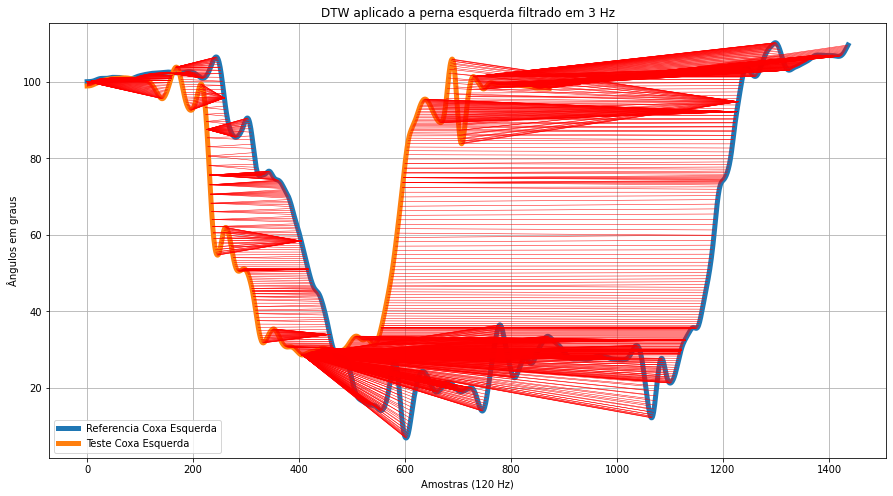

In [470]:
# Aplicando o DTW para dados filtrados em 0.5 Hz 
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_LeftUpLeg_filter_05Hz, label = 'Referencia Coxa Esquerda', linewidth=5)
plt.plot(angle_LeftUpLeg_filter_05Hz, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_LeftUpLeg_05Hz[:, 0])):
    plt.plot([paths_LeftUpLeg_05Hz[i, 0], paths_LeftUpLeg_05Hz[i, 1]], 
             ([ref_angle_LeftUpLeg_filter_05Hz[paths_LeftUpLeg_05Hz[i,0]], 
             angle_LeftUpLeg_filter_05Hz[paths_LeftUpLeg_05Hz[i,1]]]), 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a perna esquerda filtrado em 0.5 Hz')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()



# Aplicando o DTW para dados filtrados em 3 Hz
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_LeftUpLeg_filter_3Hz, label = 'Referencia Coxa Esquerda', linewidth=5)
plt.plot(angle_LeftUpLeg_filter_3Hz, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_LeftUpLeg_3Hz[:, 0])):
    plt.plot([paths_LeftUpLeg_3Hz[i, 0], paths_LeftUpLeg_3Hz[i, 1]], 
             ([ref_angle_LeftUpLeg_filter_3Hz[paths_LeftUpLeg_3Hz[i,0]], 
             angle_LeftUpLeg_filter_3Hz[paths_LeftUpLeg_3Hz[i,1]]]), 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a perna esquerda filtrado em 3 Hz')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()

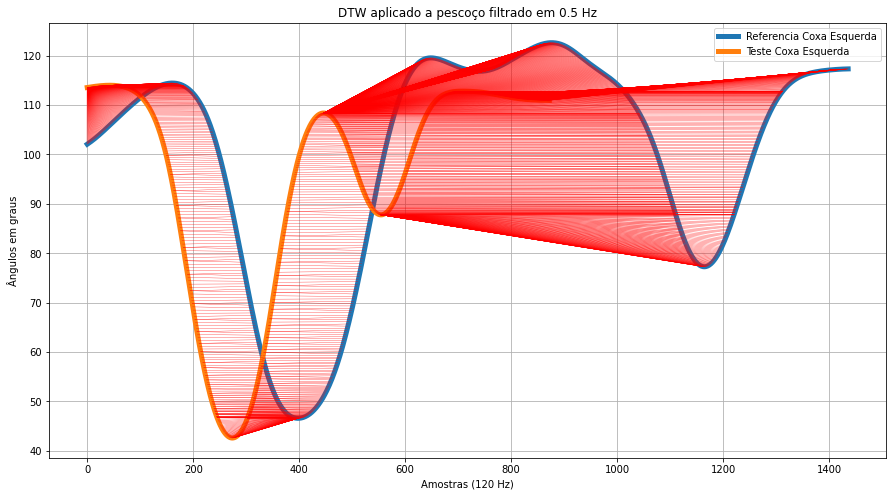

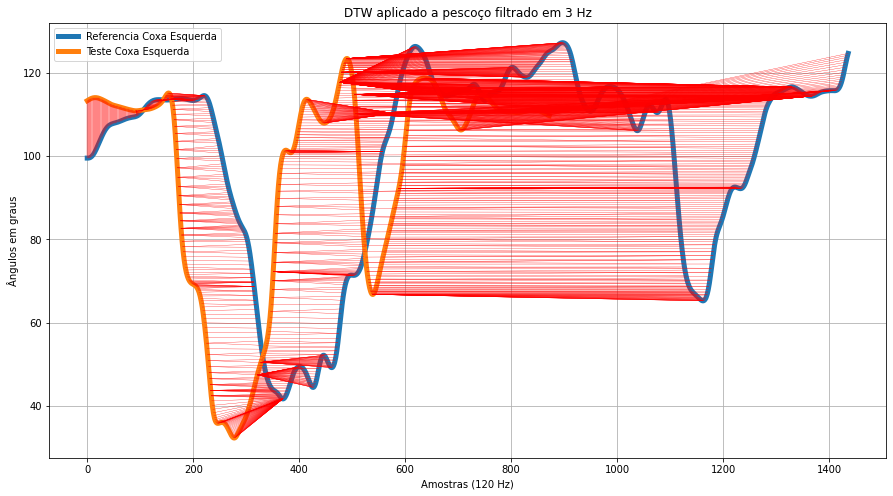

In [471]:
# Aplicando o DTW para dados filtrados em 0.5 Hz 
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_Neck_filter_05Hz, label = 'Referencia Coxa Esquerda', linewidth=5)
plt.plot(angle_Neck_filter_05Hz, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_Neck_05Hz[:, 0])):
    plt.plot([paths_Neck_05Hz[i, 0], paths_Neck_05Hz[i, 1]], 
             ([ref_angle_Neck_filter_05Hz[paths_Neck_05Hz[i,0]], 
             angle_Neck_filter_05Hz[paths_Neck_05Hz[i,1]]]), 'r', linewidth=0.3)
plt.legend()
plt.title('DTW aplicado a pescoço filtrado em 0.5 Hz')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()


# Aplicando o DTW para dados filtrados em 3 Hz 
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_Neck_filter_3Hz, label = 'Referencia Coxa Esquerda', linewidth=5)
plt.plot(angle_Neck_filter_3Hz, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_Neck_3Hz[:, 0])):
    plt.plot([paths_Neck_3Hz[i, 0], paths_Neck_3Hz[i, 1]], 
             ([ref_angle_Neck_filter_3Hz[paths_Neck_3Hz[i,0]], 
             angle_Neck_filter_3Hz[paths_Neck_3Hz[i,1]]]), 'r', linewidth=0.3)
plt.legend()
plt.title('DTW aplicado a pescoço filtrado em 3 Hz')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
#plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()

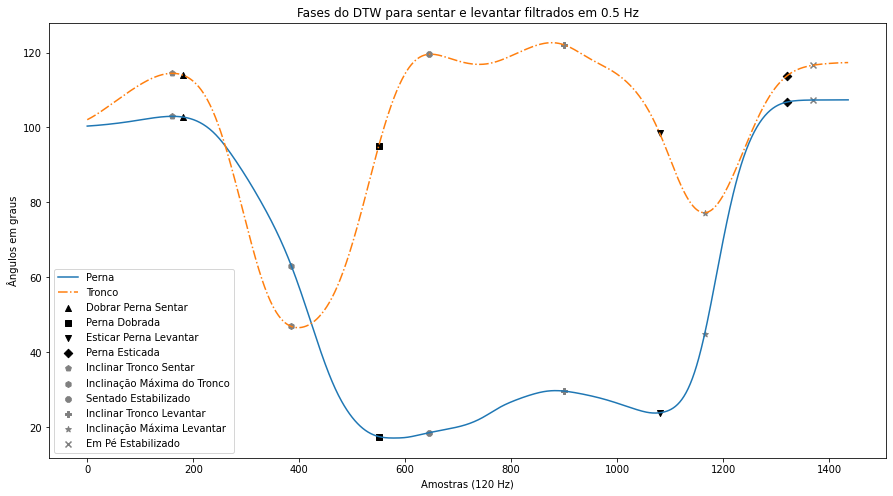

In [497]:
estimated_targets_left_up_leg_05 = [ 180, 550, 1080, 1320]
estimated_targets_neck_05 = [ 160, 385, 645, 900, 1165, 1370]


markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_left_up_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_neck = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
#phases_colors = ['black', 'gray', 'red', 'purple', 'yellow', 'green',]


plt.figure(figsize=[15,8])
plt.plot(ref_angle_LeftUpLeg_filter_05Hz, label='Perna')
plt.plot(ref_angle_Neck_filter_05Hz, label='Tronco', linestyle='-.')

for i in range(len(estimated_targets_left_up_leg_05)):    
    plt.scatter(estimated_targets_left_up_leg_05[i], ref_angle_LeftUpLeg_filter_05Hz[estimated_targets_left_up_leg_05[i]], 
            marker=markers[i], color='black', label=rowing_phases_left_up_leg[i])
    plt.scatter(estimated_targets_left_up_leg_05[i], ref_angle_Neck_filter_05Hz[estimated_targets_left_up_leg_05[i]], 
            marker=markers[i], color='black')
    
for i in range(len(estimated_targets_neck_05)):    
    plt.scatter(estimated_targets_neck_05[i], ref_angle_LeftUpLeg_filter_05Hz[estimated_targets_neck_05[i]], 
            marker=markers[i+4], color='gray', label=rowing_phases_neck[i])
    plt.scatter(estimated_targets_neck_05[i], ref_angle_Neck_filter_05Hz[estimated_targets_neck_05[i]], 
            marker=markers[i+4], color='gray')

plt.title('Fases do DTW para sentar e levantar filtrados em 0.5 Hz')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid(False)
plt.axis(True)
#plt.savefig('Fases do DTW para sentar e levantar.jpeg', format = 'jpeg')
plt.show()


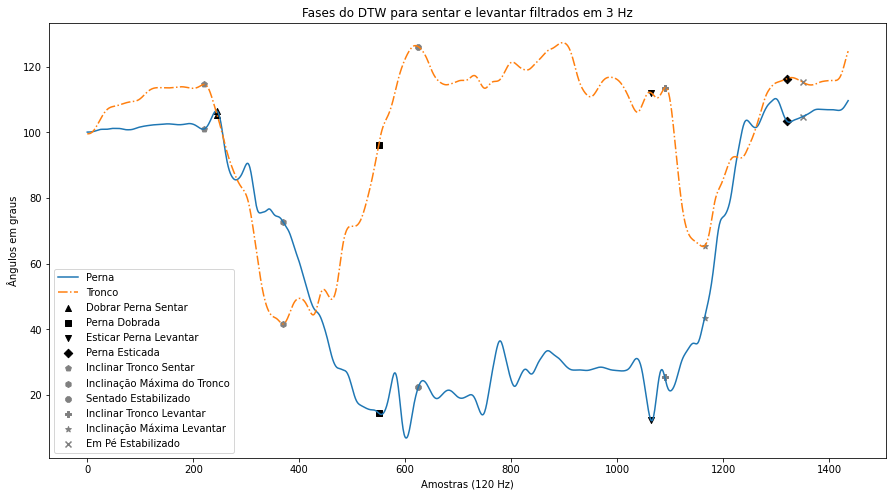

In [498]:
estimated_targets_left_up_leg_3 = [ 245, 550, 1064, 1320]
estimated_targets_neck_3 = [ 220, 370, 625, 1090, 1165, 1350]


markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_left_up_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_neck = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
#phases_colors = ['black', 'gray', 'red', 'purple', 'yellow', 'green',]


plt.figure(figsize=[15,8])
plt.plot(ref_angle_LeftUpLeg_filter_3Hz, label='Perna')
plt.plot(ref_angle_Neck_filter_3Hz, label='Tronco', linestyle='-.')

for i in range(len(estimated_targets_left_up_leg_3)):    
    plt.scatter(estimated_targets_left_up_leg_3[i], ref_angle_LeftUpLeg_filter_3Hz[estimated_targets_left_up_leg_3[i]], 
            marker=markers[i], color='black', label=rowing_phases_left_up_leg[i])
    plt.scatter(estimated_targets_left_up_leg_3[i], ref_angle_Neck_filter_3Hz[estimated_targets_left_up_leg_3[i]], 
            marker=markers[i], color='black')
    
for i in range(len(estimated_targets_neck_3)):    
    plt.scatter(estimated_targets_neck_3[i], ref_angle_LeftUpLeg_filter_3Hz[estimated_targets_neck_3[i]], 
            marker=markers[i+4], color='gray', label=rowing_phases_neck[i])
    plt.scatter(estimated_targets_neck_3[i], ref_angle_Neck_filter_3Hz[estimated_targets_neck_3[i]], 
            marker=markers[i+4], color='gray')

plt.title('Fases do DTW para sentar e levantar filtrados em 3 Hz')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid(False)
plt.axis(True)
#plt.savefig('Fases do DTW para sentar e levantar.jpeg', format = 'jpeg')
plt.show()


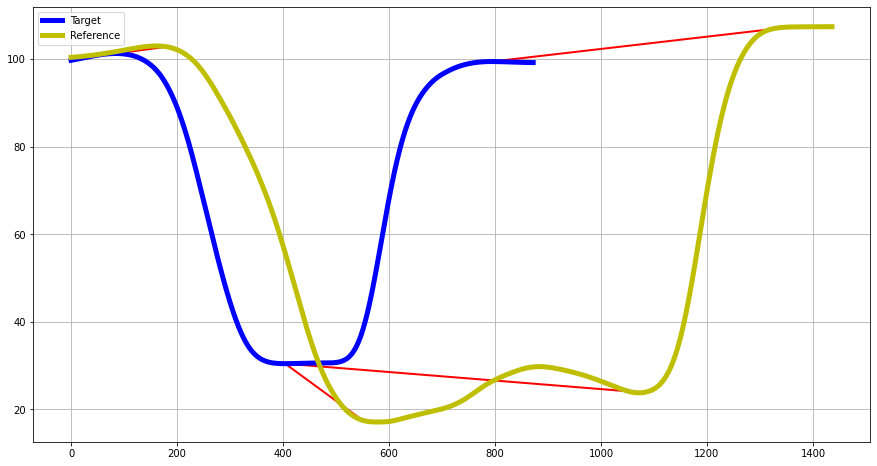

In [499]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_LeftUpLeg_05Hz[:, 0])):
    if paths_LeftUpLeg_05Hz[i, 0] == estimated_targets_left_up_leg_05[k]:
        plt.plot([paths_LeftUpLeg_05Hz[i, 0], paths_LeftUpLeg_05Hz[i, 1]], 
                 ([ref_angle_LeftUpLeg_filter_05Hz[paths_LeftUpLeg_05Hz[i,0]], 
                 angle_LeftUpLeg_filter_05Hz[paths_LeftUpLeg_05Hz[i,1]]]), 'r', linewidth=2)
        if paths_LeftUpLeg_05Hz[i + 1, 0] == estimated_targets_left_up_leg_05[k]:
            pass
        else:
            k = k + 1
    if k == 4:
        k = 0
        
plt.plot(angle_LeftUpLeg_filter_05Hz, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_LeftUpLeg_filter_05Hz, color = 'y',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()


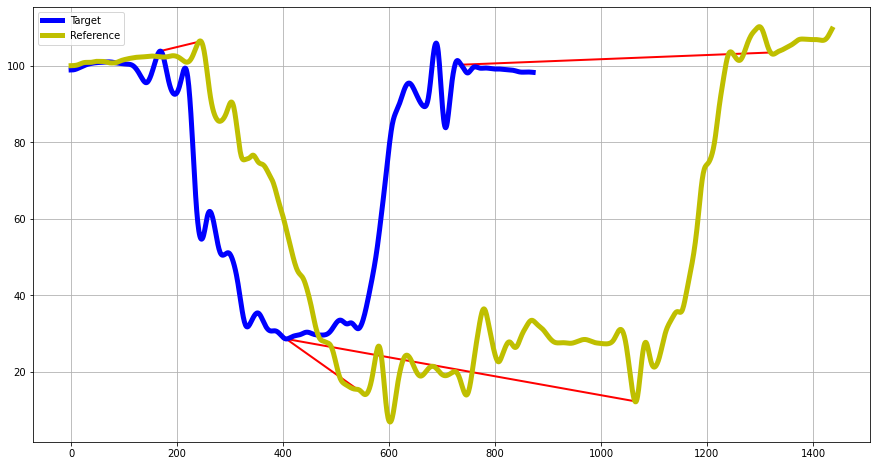

In [500]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_LeftUpLeg_3Hz[:, 0])):
    if paths_LeftUpLeg_3Hz[i, 0] == estimated_targets_left_up_leg_3[k]:
        plt.plot([paths_LeftUpLeg_3Hz[i, 0], paths_LeftUpLeg_3Hz[i, 1]], 
                 ([ref_angle_LeftUpLeg_filter_3Hz[paths_LeftUpLeg_3Hz[i,0]], 
                 angle_LeftUpLeg_filter_3Hz[paths_LeftUpLeg_3Hz[i,1]]]), 'r', linewidth=2)
        if paths_LeftUpLeg_3Hz[i + 1, 0] == estimated_targets_left_up_leg_3[k]:
            pass
        else:
            k = k + 1
    if k == 4:
        k = 0
        
plt.plot(angle_LeftUpLeg_filter_3Hz, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_LeftUpLeg_filter_3Hz, color = 'y',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()

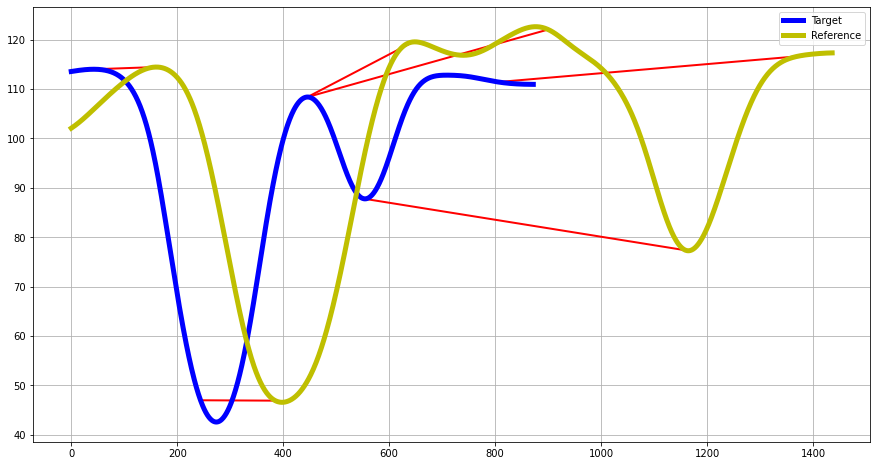

In [501]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_Neck_05Hz[:, 0])):
    if paths_Neck_05Hz[i, 0] == estimated_targets_neck_05[k]:
        plt.plot([paths_Neck_05Hz[i, 0], paths_Neck_05Hz[i, 1]], 
                 ([ref_angle_Neck_filter_05Hz[paths_Neck_05Hz[i,0]], 
                 angle_Neck_filter_05Hz[paths_Neck_05Hz[i,1]]]), 'r', linewidth=2)
        if paths_Neck_05Hz[i + 1, 0] == estimated_targets_neck_05[k]:
            pass
        else:
            k = k + 1
    if k == 6:
        k = 0
        
plt.plot(angle_Neck_filter_05Hz, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_Neck_filter_05Hz, color = 'y',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()

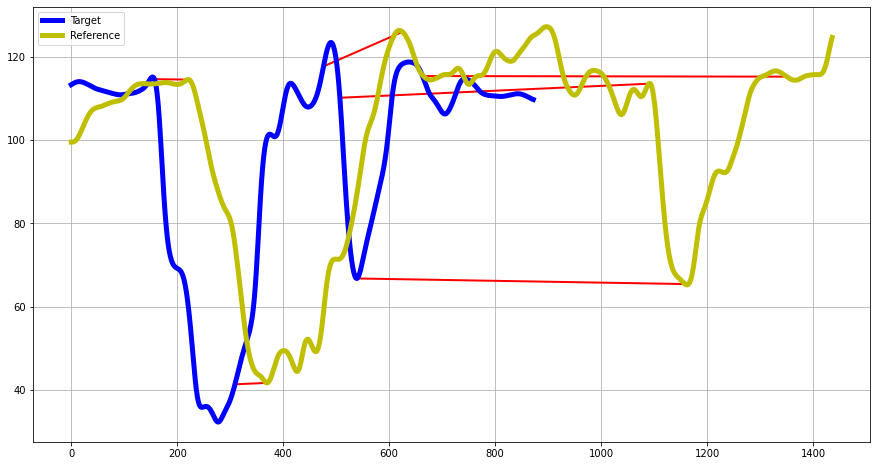

In [502]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_Neck_3Hz[:, 0])):
    if paths_Neck_3Hz[i, 0] == estimated_targets_neck_3[k]:
        plt.plot([paths_Neck_3Hz[i, 0], paths_Neck_3Hz[i, 1]], 
                 ([ref_angle_Neck_filter_3Hz[paths_Neck_3Hz[i,0]], 
                 angle_Neck_filter_3Hz[paths_Neck_3Hz[i,1]]]), 'r', linewidth=2)
        if paths_Neck_3Hz[i + 1, 0] == estimated_targets_neck_3[k]:
            pass
        else:
            k = k + 1
    if k == 6:
        k = 0
        
plt.plot(angle_Neck_filter_3Hz, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_Neck_filter_3Hz, color = 'y',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()